## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [225]:
import scipy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from itertools import chain
import tensorflow as tf
from tensorflow import keras
from Levenshtein import *
from tensorflow.keras.callbacks import EarlyStopping
from seq_diff import diff_html

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [4]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [5]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [6]:
reverse_char_index = dict((i, char) for char, i in token_index.items())
decode_seq = lambda seq: [ ''.join([ reverse_char_index[i] for i in s ]) for s in np.argmax(seq, axis = 2)]

In [17]:
X_data = encoder_input_data#[:1000]
Y_data = decoder_input_data#[:1000]
print("X_data", X_data.shape)
print("Y_data", Y_data.shape)

X_data (4368, 3822, 4)
Y_data (4368, 3822, 4)


## Inference

In [194]:
model = keras.models.load_model("data/ncbi_02/model_gru_bi_256_8")
model

In [195]:
i = 5
x1 = decode_seq(X_data[i:i+1,:,:])[0]
y1 = decode_seq(Y_data[i:i+1,:,:])[0]

_ = diff_html(x1, y1, display_a=True, display_b=True)

In [200]:
yp1 = decode_seq(model.predict([ X_data[i:i+1,:,:], np.array([0.01])]))[0]

_ = diff_html(y1, yp1, display_a=True, display_b=True)

# Random rate search

In [243]:
rand_rates = []
for r in tqdm(np.arange(0, 0.105, 0.005)):
    Y_pred = model.predict([X_data, np.full((len(X_data)), r)])
    cc = keras.losses.CategoricalCrossentropy()(X_data, Y_pred).numpy()
    rand_rates.append([r, cc])
rand_rates = np.array(rand_rates)

  0%|          | 0/21 [00:00<?, ?it/s]

In [244]:
from scipy.optimize import curve_fit
func = lambda t, a, b, c: a * t * t + b * t + c
p, _ = curve_fit(func, rand_rates[:,0],  rand_rates[:,1])

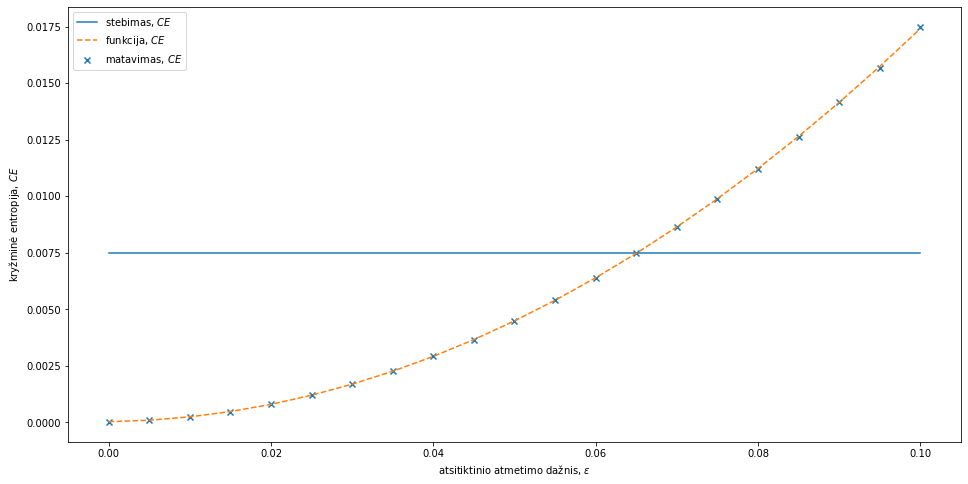

In [245]:
plt.plot(rand_rates[:,0], np.full_like(rand_rates[:,1], 0.0074873627), label="stebimas, $CE$")
plt.plot(rand_rates[:,0], func(rand_rates[:,0], p[0], p[1], p[2]), '--', label="funkcija, $CE$")
plt.scatter(rand_rates[:,0], rand_rates[:,1], marker='x', label="matavimas, $CE$")
plt.ylabel('kryžminė entropija, $CE$')
plt.xlabel('atsitiktinio atmetimo dažnis, $ε$')

plt.legend()
plt.show()

In [270]:
p, _ = curve_fit(func, rand_rates[:,1],  rand_rates[:,0])
epsilon = func(0.0074873627, p[0], p[1], p[2])
epsilon

0.06639055524867393

# Metrics

In [247]:
Y_pred = model.predict([X_data, np.full((len(X_data)), epsilon)])
Y_pred.shape

(4368, 3822, 4)

In [248]:
keras.losses.CategoricalCrossentropy()(X_data, Y_data).numpy()

0.0074873627

In [249]:
keras.losses.CategoricalCrossentropy()(X_data, Y_pred).numpy()

0.0077611385

In [250]:
keras.losses.CategoricalCrossentropy()(Y_data, Y_pred).numpy()

0.014839249

In [251]:
if Y_pred_prev is not None:
    print(keras.losses.CategoricalCrossentropy()(Y_pred_prev, Y_pred).numpy())
Y_pred_prev = Y_pred.copy()

0.010361176


# X vs Y true vs Y pred

In [252]:
cce = []
for i in tqdm(range(len(decoder_target_data))):
    cce.append([
        keras.losses.CategoricalCrossentropy()(X_data[i:i + 1], Y_data[i:i + 1]).numpy(),
        keras.losses.CategoricalCrossentropy()(X_data[i:i + 1], Y_pred[i:i + 1]).numpy(),
        keras.losses.CategoricalCrossentropy()(Y_data[i:i + 1], Y_pred[i:i + 1]).numpy()
    ])
cce = np.array(cce)

  0%|          | 0/4368 [00:00<?, ?it/s]

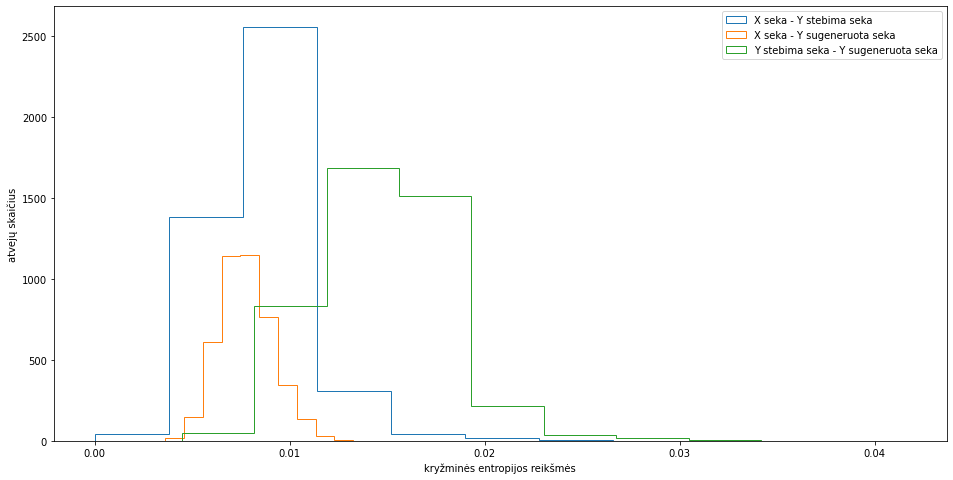

In [253]:
plt.hist(cce[:,0], fill=False, bins = 10, histtype='step', label="X seka - Y stebima seka")
plt.hist(cce[:,1], fill=False, bins = 10, histtype='step', label="X seka - Y sugeneruota seka")
plt.hist(cce[:,2], fill=False, bins = 10, histtype='step', label="Y stebima seka - Y sugeneruota seka")
plt.xlabel('kryžminės entropijos reikšmės')
plt.ylabel('atvejų skaičius')
plt.legend()
plt.show()

In [254]:
X_secs = decode_seq(X_data)
Y_secs = decode_seq(Y_data)
Y_pred_secs = decode_seq(Y_pred)

In [255]:
lev_distances = []
for x,y,p in tqdm(list(zip(X_secs, Y_secs, Y_pred_secs))):
    lev_distances.append([ 
        distance(x,y), distance(x,p), distance(y,p)
    ])
lev_distances = np.array(lev_distances)

  0%|          | 0/4368 [00:00<?, ?it/s]

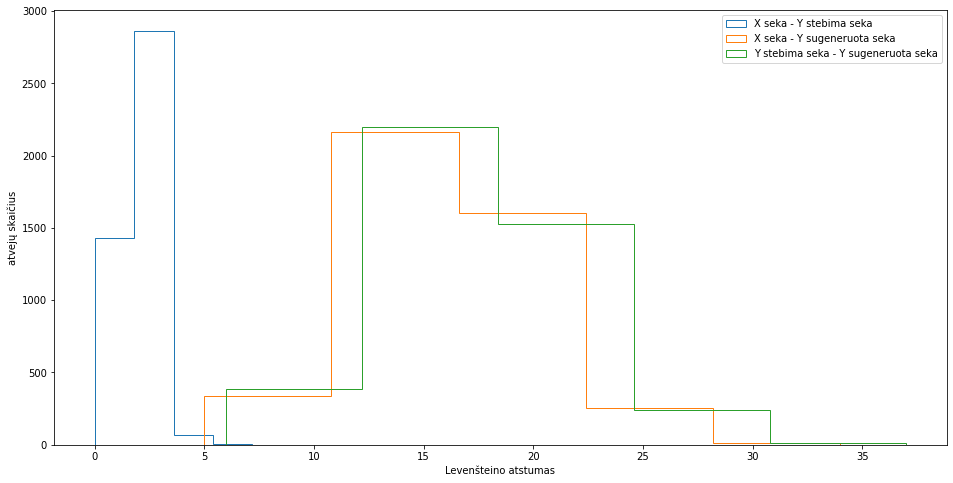

In [260]:
plt.hist(lev_distances[:,0], fill=False, bins = 5, histtype='step', label="X seka - Y stebima seka")
plt.hist(lev_distances[:,1], fill=False, bins = 5, histtype='step', label="X seka - Y sugeneruota seka")
plt.hist(lev_distances[:,2], fill=False, bins = 5, histtype='step', label="Y stebima seka - Y sugeneruota seka")
plt.xlabel('Levenšteino atstumas')
plt.ylabel('atvejų skaičius')
plt.legend()
plt.show()

In [258]:
lev_ratio = []
for x,y,p in tqdm(list(zip(X_secs, Y_secs, Y_pred_secs))):
    lev_ratio.append([ 
        ratio(x,y), ratio(x,p), ratio(y,p)
    ])
lev_ratio = np.array(lev_ratio)

  0%|          | 0/4368 [00:00<?, ?it/s]

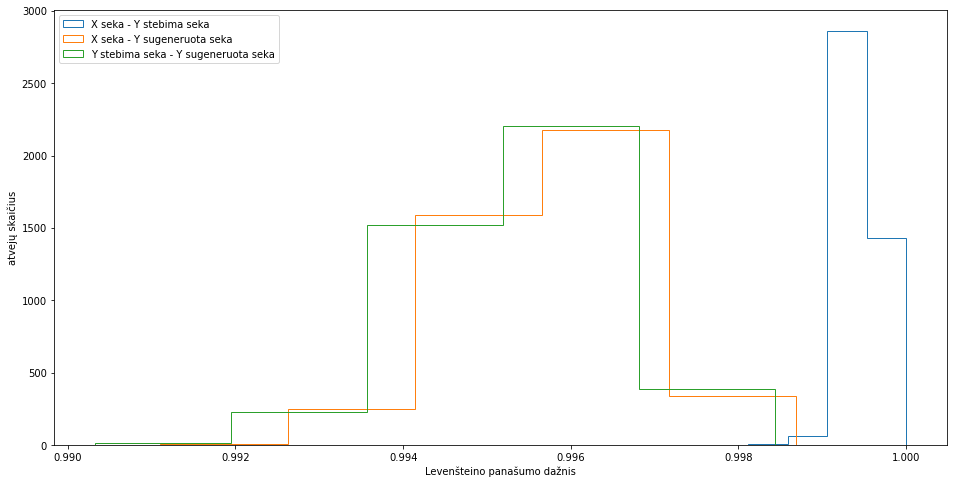

In [261]:
plt.hist(lev_ratio[:,0], fill=False, bins = 5, histtype='step', label="X seka - Y stebima seka")
plt.hist(lev_ratio[:,1], fill=False, bins = 5, histtype='step', label="X seka - Y sugeneruota seka")
plt.hist(lev_ratio[:,2], fill=False, bins = 5, histtype='step', label="Y stebima seka - Y sugeneruota seka")
plt.xlabel('Levenšteino panašumo dažnis')
plt.ylabel('atvejų skaičius')
plt.legend()
plt.show()

In [262]:
ham_distances = []
for x,y,p in tqdm(list(zip(X_secs, Y_secs, Y_pred_secs))):
    ham_distances.append([ 
        hamming(x,y), hamming(x,p), hamming(y,p)
    ])
ham_distances = np.array(ham_distances)

  0%|          | 0/4368 [00:00<?, ?it/s]

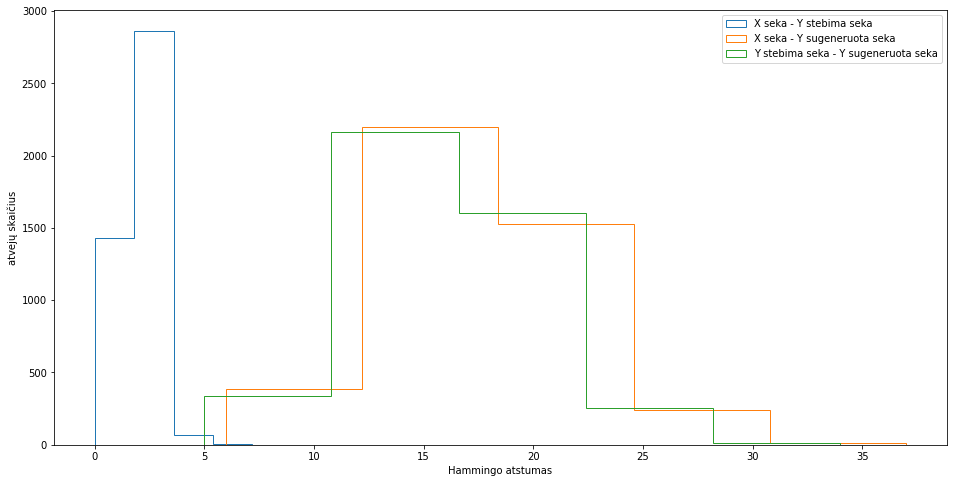

In [263]:
plt.hist(ham_distances[:,0], fill=False, bins = 5, histtype='step', label="X seka - Y stebima seka")
plt.hist(ham_distances[:,2], fill=False, bins = 5, histtype='step', label="X seka - Y sugeneruota seka")
plt.hist(ham_distances[:,1], fill=False, bins = 5, histtype='step', label="Y stebima seka - Y sugeneruota seka")
plt.xlabel('Hammingo atstumas')
plt.ylabel('atvejų skaičius')
plt.legend()
plt.show()

# Mutacijos

In [264]:
mut01 = np.sum(
    (np.subtract(
        np.argmax(X_data, axis = 2), 
        np.argmax(Y_data, axis = 2)
    ) != 0.0).astype(int), axis = 0)

In [265]:
mut02 = np.sum(
    (np.subtract(
        np.argmax(X_data, axis = 2), 
        np.argmax(Y_pred, axis = 2)
    ) != 0.0).astype(int), axis = 0)

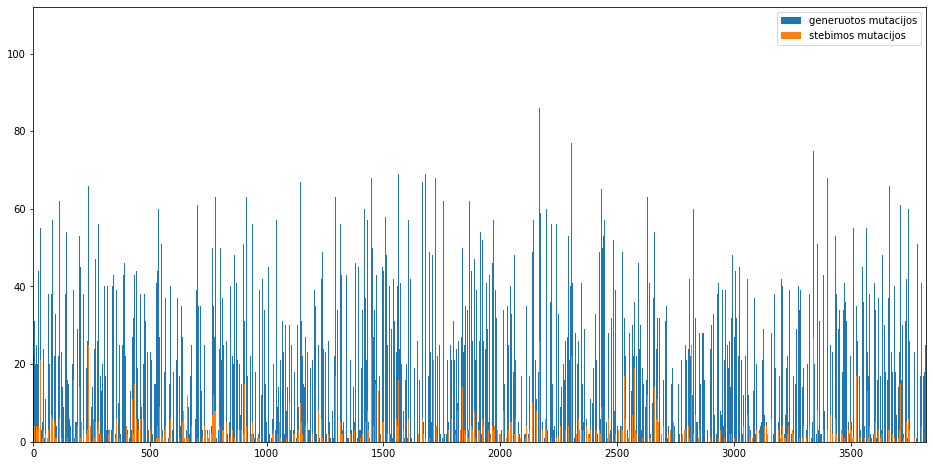

In [266]:
x_range = list(range(len(mut01)))
plt.bar(x_range, mut02, bottom = mut01, label = 'generuotos mutacijos')
plt.bar(x_range, mut01, label = 'stebimos mutacijos')
#plt.ylim(0, 200.0)
plt.xlim(0, len(mut01))
plt.legend()
plt.show()

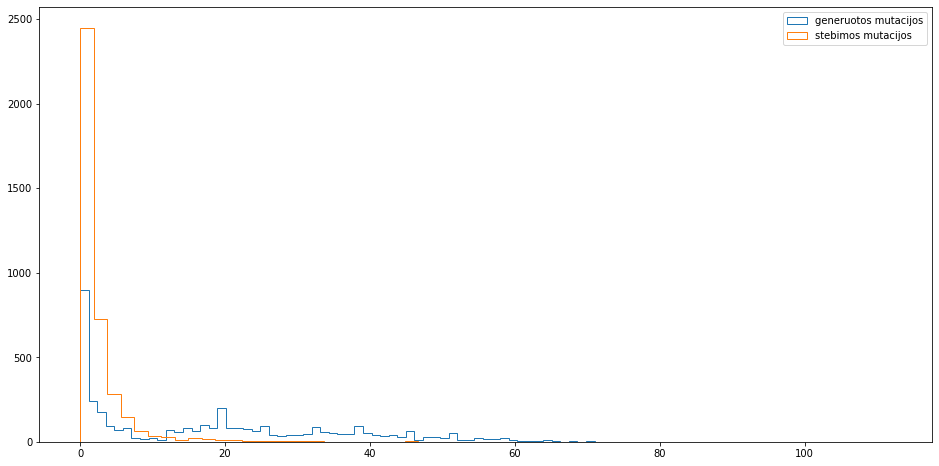

In [267]:
plt.hist(mut02, bins = 60, label = 'generuotos mutacijos', fill = False, histtype='step')
plt.hist(mut01, bins = 60, label = 'stebimos mutacijos', fill = False, histtype='step')
plt.legend()
plt.show()

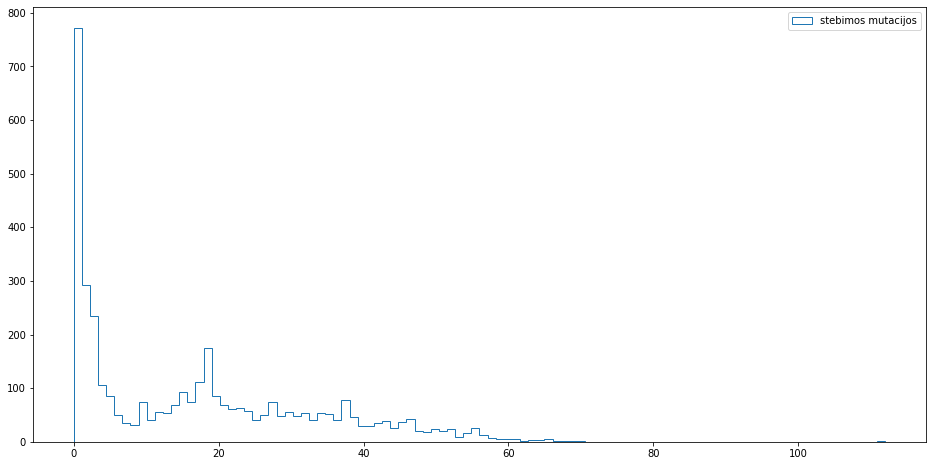

In [268]:
plt.hist(abs(mut02 - mut01), bins = 100, label = 'stebimos mutacijos', fill = False, histtype='step')
plt.legend()
plt.show()

# Siblings

In [271]:
Y_pred_sibs = []
for i in tqdm(range(10)):
    y_ = model.predict([ X_data, np.full((len(X_data)), epsilon)])
    Y_pred_sibs.append([])
    for j in range(len(y_)):
        Y_pred_sibs[i].append(
            keras.losses.CategoricalCrossentropy()(X_data[j:j + 1], y_[j:j + 1]).numpy()
        )
Y_pred_sibs = np.array(Y_pred_sibs)

  0%|          | 0/10 [00:00<?, ?it/s]

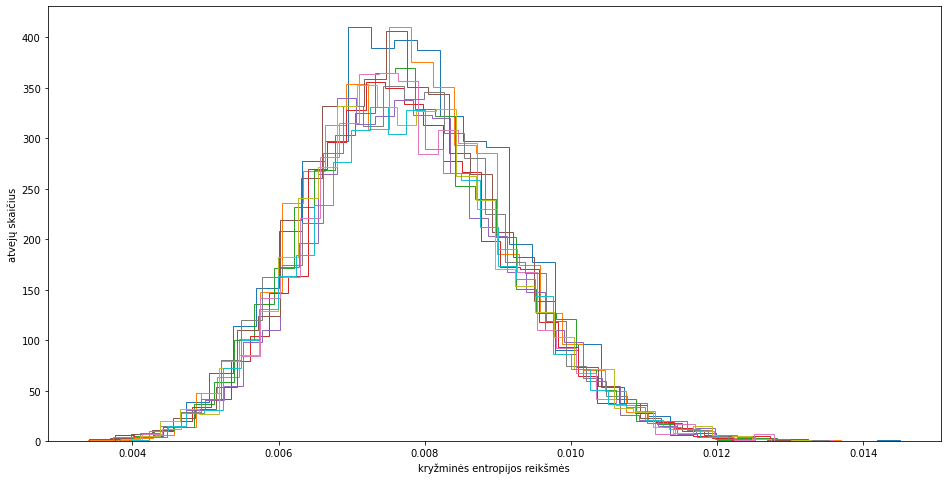

In [272]:
for i in range(len(Y_pred_sibs)):
    plt.hist(Y_pred_sibs[i], fill=False, bins = 35, histtype='step')
plt.xlabel('kryžminės entropijos reikšmės')
plt.ylabel('atvejų skaičius')
plt.show()